In [36]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [37]:
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-2]) #remonter au dossier root du projet
os.chdir(path_root)
path = PureWindowsPath(os.getcwd() + "/data/input/data_middle_age_epistemology.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"

class_len = corpus["category"].value_counts()
name_of_minority_class = class_len.index[class_len.argmin()]
number_of_minority_class = class_len[class_len.argmin()]
minority_class = corpus.loc[corpus["category"] == name_of_minority_class, :]
majority_class = corpus.loc[corpus["category"] != name_of_minority_class, :]
majority_class_sampled = majority_class.sample(number_of_minority_class, random_state=42)
corpus = pd.concat([majority_class_sampled, minority_class], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())
print(corpus.id.duplicated().any()) #Verifier qu'il n'y a pas d'id en doublon
print(corpus.index.duplicated().any())
corpus

0    357
1    357
Name: category_bin, dtype: int64
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,"Ce n’est donc pas une agrégation de temps, ou de secondes, mais un état simple, sans compositions. Voir aussi juste après:",donc agrégation temps seconde état simple sans composition voir aussi juste après,epistemology,122,0
1,1,"Bien sûr, je ne fais pas référence aux érudits qui croient que Van Til a offert des perspectives utiles en théologie et/ou en apologétique et qui souhaitent développer et prolonger son travail. Je ne parle pas non plus de ceux qui souhaitent corriger ce qu’ils croient être des interprétations erronées de Van Til. Je veux parler de ceux qui traitent Van Til comme s’il était pratiquement infaillible et au-delà de toute critique. Il y a un culte de la personnalité autour de Van Til qui est différent de tout ce que j’ai vu avec d’autres personnages dans l’histoire de la théologie réformée. Charles Hodge n’est pas traité de cette façon. J. Gresham Machen n’est pas traité de cette façon. Même Jean Calvin n’est pas traité de cette façon. Je ne connais personne d’autre qui soit traité de cette façon. Pour certains, Van Til est pratiquement intouchable, mais ils sont prêts à critiquer l’enseignement des autres. Van Til est traité par certains presque comme si ses œuvres étaient inspirées et comme si le critiquer revenait à critiquer l’Écriture.",bien sûr fais référence érudit croient van til a offert perspective utile théologie etou apologétique souhaitent développer prolonger travail parle non plus ceux souhaitent corriger croient être interprétation erronées van til veux parler ceux traitent van til comme pratiquement infaillible au-delà toute critique a culte personnalité autour van til différent tout vu autres personnage histoire théologie réformée charles hodge traité cette façon gresham machen traité cette façon jean calvin traité cette façon connais personne autre traité cette façon certain van til pratiquement intouchable prêt critiquer enseignement autres van til traité certain presque comme si œuvres inspirées comme si critiquer revenait critiquer écriture,middle_age,1051,1
...,...,...,...,...,...,...
712,712,"> L’existence de Dieu est un article de foi ; mais les articles de foi ne se > démontrent pas ; car la démonstration engendre la science, mais l’objet de > la foi est ce dont la vérité n’apparaît pas, selon l’épître aux Hébreux (11, > 1) – Summa Ia, Q2, a2",existence dieu article foi article foi démontrent car démonstration engendre science objet foi dont vérité apparaît selon épître hébreux – summa ia q a,epistemology,256,0
713,713,"80. VAN TIL, _The Defense of the Faith_ , 4e éd., p. 340–341.[↩]",van til the defense of the faith e éd p –↩,middle_age,66,1


In [38]:
X = corpus["message_preprocessed"]
y = corpus["category"]
y = corpus["category_bin"]
indices = corpus["id"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
# y_train.value_counts()
# print(indices_train, indices_test)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
indices_test

120    120
329    329
      ... 
465    465
83      83
Name: id, Length: 236, dtype: int64

In [39]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 

# Cross validation
#Methode version automatisee facile grace a la fonction RepeatedStratifiedKFold de sklearn
#Selection de modeles avec la k cross validation pour determiner le meilleur
#Modeles utilisés dans les papiers :
# LogisticRegression, MultinomialNB (= naive bayes), SVC (SVD petit data), SGDClassifier (SVD grand data)
# DecisionTreeClassifier, RandomForestClassifier
# AdaBoostClassifier, MLPClassifier
pd.set_option("display.precision", 2)
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'f1_macro']
scoring = ['f1_macro', 'f1_micro']
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
# models.append(('MLPClassifier', MLPClassifier(max_iter=500))) car diverge donc trop long
models.append(('SGDClassifier', SGDClassifier()))
models.append(('SVM', SVC()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
 
# evaluate each model in turn
results = []
names = []
num_iter = 2
for name, model in models:
    sum_test_accuracy = 0
    sum_test_f1 = 0
    sum_test_recall = 0
    sum_test_precision = 0
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=num_iter, random_state=None)
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=kfold, scoring=scoring)
    for k, scores in cv_results.items():
        cv_results[k] = round(np.mean(scores), 4) #on fait la moyenne de chaque score (rappel, precision, etc.) pour les k experiences
    print((str(list(cv_results.items())[2:])+" ({0})").format(name)) #2: pour ignorer les info inutiles

[('test_f1_macro', 0.923), ('test_f1_micro', 0.9236)] (LR)
[('test_f1_macro', 0.9277), ('test_f1_micro', 0.9279)] (AdaBoostClassifier)
[('test_f1_macro', 0.9381), ('test_f1_micro', 0.9382)] (KNN)
[('test_f1_macro', 0.9443), ('test_f1_micro', 0.9446)] (RandomForest)
[('test_f1_macro', 0.958), ('test_f1_micro', 0.9582)] (SGDClassifier)
[('test_f1_macro', 0.9238), ('test_f1_micro', 0.9247)] (SVM)
[('test_f1_macro', 0.9257), ('test_f1_micro', 0.9258)] (DecisionTreeClassifier)


In [40]:
# Learning curves du modele selectionne : performances du modele en fonction de la taille du trainset
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#Entrees
    #train_sizes (liste de float) : tailles du train en pourcentage 
    #cv_param : parametres de type kfold pour la cross validation
def get_learning_curve(model, X_train, y_train, cv_param, scoring, train_sizes, n_jobs=-1):
    # print("train_sizes =", 100 * train_sizes * len(y_train))
    train_sizes, train_scores, cv_scores = learning_curve(model, X_train, y_train, cv=cv_param, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    # learning_curve(AdaBoostClassifier(), X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)
    model_name = str(model)
    plt.figure()
    train_plot_label = scoring.capitalize() + " sur le trainset"
    cv_plot_label = scoring.capitalize() + " sur le cvset"
    title = scoring.capitalize() + " sur le trainset et sur le cvset en fonction de la taille du trainset pour " + model_name
    plt.plot(train_sizes, train_scores_mean, label=train_plot_label, color="b")
    plt.plot(train_sizes, cv_scores_mean, label=cv_plot_label, color="r")
    plt.title(title)
    plt.xlabel("Taille du trainset", fontsize=12)
    plt.ylabel(scoring.capitalize(), fontsize=12)
    plt.legend(loc="upper right")
    plt.show()

k = 10
# kfold = StratifiedKFold(n_splits=k, random_state=None, shuffle=True) #n_splits = k de la k-fold cv, le nombre de fold
kfold = RepeatedStratifiedKFold(n_splits=k, n_repeats=2, random_state=None)
scoring = 'accuracy'
cv_param = kfold
num_experiences = 10
train_sizes = np.linspace(0.1, 1.0, num_experiences)
# train_sizes = np.linspace(0.001, 1.0, num_experiences)
n_jobs = -1

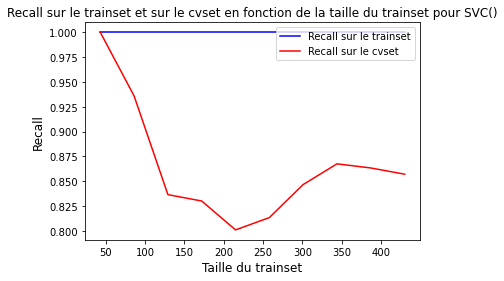

In [41]:
model = SVC() #le meilleur modele garde apres cross validation 
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "recall", train_sizes, n_jobs)

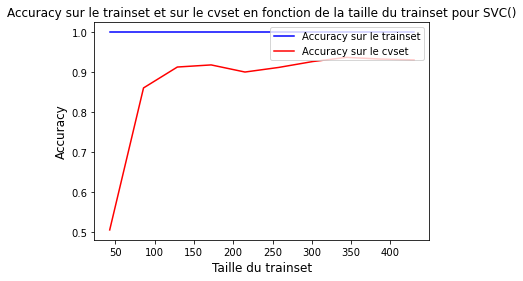

In [42]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "accuracy", train_sizes, n_jobs)

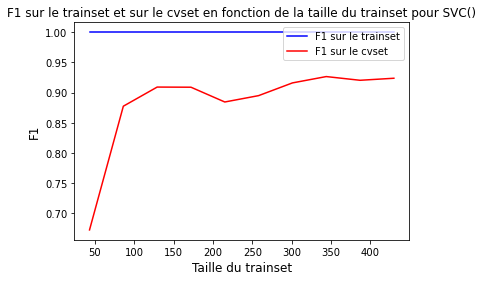

In [43]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "f1", train_sizes, n_jobs)

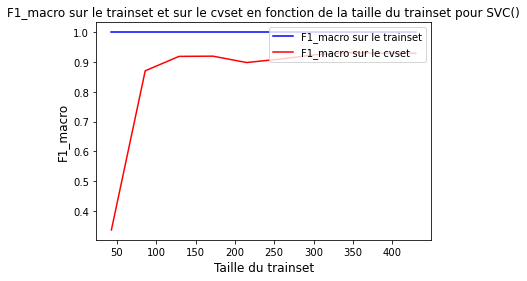

In [45]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "f1_macro", train_sizes, n_jobs)

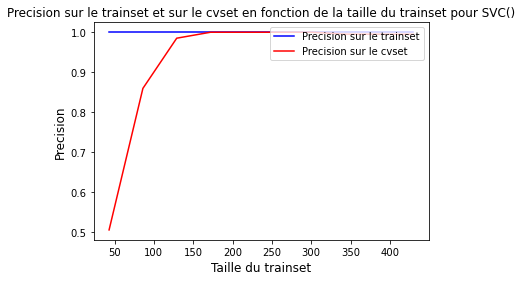

In [44]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "precision", train_sizes, n_jobs)